[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/DeepFM.ipynb)

> This notebook runs DeepFM on MovieLens1M dataset. We'll use YouTubeDNN for generating candidates and DeepFM for ranking these candidates.

> Only movies with ratings larger than 3 are treated as 'positive' samples for each user. Every last 10 'positive' movies of each user are held out for testing.

## Table of Contents:
* [Prepare data for matching](#section-0)
* [Train match model and export embeddings](#section-1)
* [Use Faiss to generate candidates](#section-2)
* [Train rank model and predict](#section-3)

**Download dataset and install packages**

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git
! pip install faiss-cpu

Cloning into 'HandyRec'...
remote: Enumerating objects: 1098, done.
remote: Counting objects: 100% (1098/1098), done.
remote: Compressing objects: 100% (846/846), done.
remote: Total 1098 (delta 395), reused 838 (delta 205), pack-reused 0
Receiving objects: 100% (1098/1098), 16.43 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (395/395), done.
     |████████████████████████████████| 8.6 MB 4.2 MB/s 


In [2]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
! unzip -o ml-1m.zip

--2022-03-31 02:40:42--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  3.71MB/s    in 1.5s    

2022-03-31 02:40:45 (3.71 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


**Import relative packages**

In [3]:
import sys
sys.path.append('./HandyRec/')

In [4]:
from handyrec.dataset.movielens import MovieMatchDataHelper, MovieRankDataHelper
from handyrec.models.match import YouTubeMatchDNN
from handyrec.models.rank import DeepFM
from handyrec.features import DenseFeature, SparseFeature, SparseSeqFeature, FeatureGroup, EmbdFeatureGroup, FeaturePool
from handyrec.layers.utils import sampledsoftmaxloss
from handyrec.dataset.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import gc

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
MATCH_EMBEDDING_DIM = 256
RANK_EMBEDDING_DIM = 128
SEQ_LEN = 40
BATCH_SIZE = 2**12
NEPOCH = 50

NEG_NUM = 10
CANDIDATE_NUM = 100

# 0. Prepare data for ranking<a name="section-0"></a>

In [7]:
match_dh = MovieMatchDataHelper('./ml-1m/')
data = match_dh.get_clean_data(sparse_features=['gender','age','occupation','zip','year'])

match_user_features = ['user_id','gender','age','occupation','zip']
match_movie_features = [f for f in data['item'].columns if f != 'title']
match_dh.gen_dataset(match_user_features+match_movie_features, data, seq_max_len=SEQ_LEN, negnum=0)

100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


In [8]:
match_train, match_train_label, match_test, match_test_label = match_dh.load_dataset(match_user_features, match_movie_features)

Load movie Features: 100%|██████████| 3/3 [00:00<00:00, 163.56it/s]


In [9]:
match_feature_dim = match_dh.get_feature_dim(data, match_user_features, match_movie_features, [])

# 1. Train match model and export embeddings <a name="section-1"></a>

In [10]:
# * add example_age^2 as showed in the original paper
match_train['example_age_2'] = match_train['example_age']**2
match_test['example_age_2'] = match_test['example_age']**2

In [11]:
match_user_dense_feats = ['example_age','example_age_2']
match_user_sparse_feats = ['user_id','gender','age','occupation','zip']

In [12]:
match_item_dense_feats = []
match_item_sparse_feats = [f for f in match_movie_features if f!='genres']
all_item_model_input = {f:np.array(data['item'][f].tolist()) for f in match_movie_features}

In [13]:
feat_pool1 = FeaturePool()

In [14]:
match_item_features = [DenseFeature(x) for x in match_item_dense_feats] +\
                [SparseFeature(x, match_feature_dim[x], MATCH_EMBEDDING_DIM) for x in match_item_sparse_feats] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, MATCH_EMBEDDING_DIM), 'genres',6)]
item_feature_group = EmbdFeatureGroup(
    name='item', 
    id_name='movie_id', 
    features=match_item_features, 
    feature_pool=feat_pool1, 
    value_dict=all_item_model_input,
    embd_dim=MATCH_EMBEDDING_DIM)

In [15]:
match_user_features = [DenseFeature(x) for x in match_user_dense_feats] +\
                [SparseFeature(x, match_feature_dim[x], MATCH_EMBEDDING_DIM) for x in match_user_sparse_feats] +\
                [SparseSeqFeature(item_feature_group, 'hist_movie_id',SEQ_LEN)]
user_feature_group = FeatureGroup('user', match_user_features, feat_pool1)

In [16]:
match_model = YouTubeMatchDNN(
    user_feature_group, item_feature_group,
    dnn_hidden_units=(512,256,MATCH_EMBEDDING_DIM), 
    dnn_dropout=0.1,
    dnn_bn=True,
    num_sampled=100
)

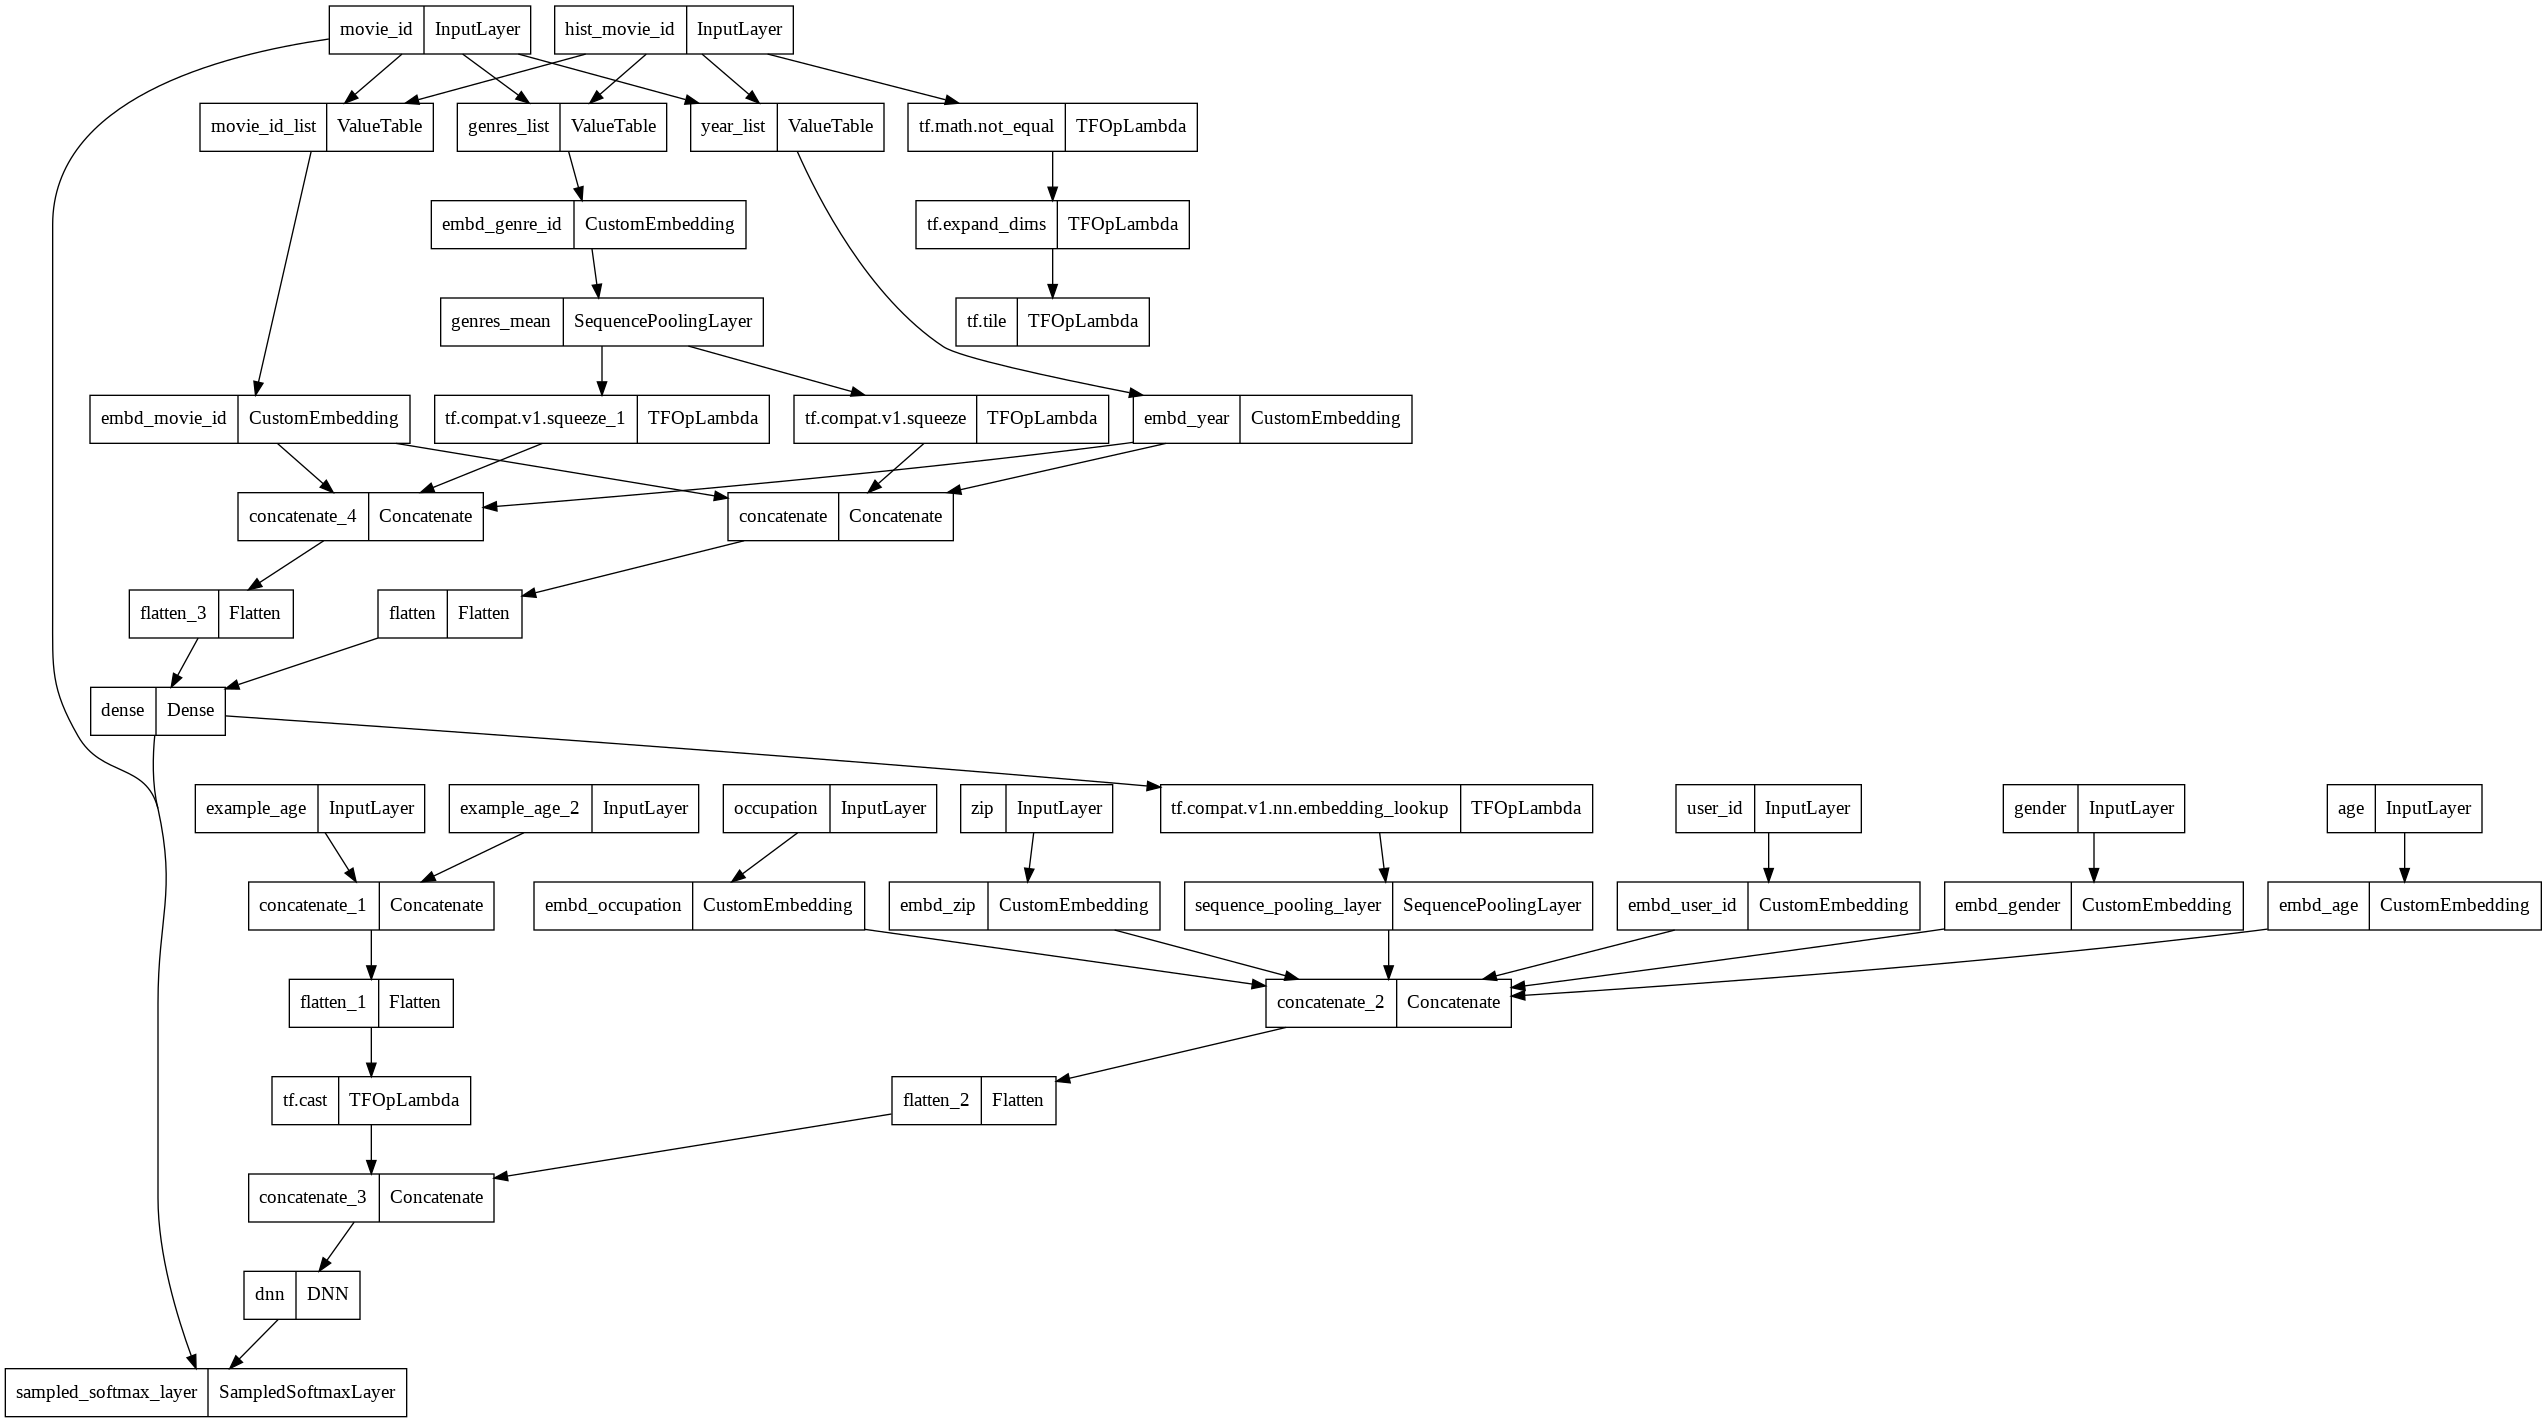

In [17]:
plot_model(match_model)

In [18]:
match_model.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-4), loss=sampledsoftmaxloss)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./match_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history = match_model.fit(match_train, match_train_label,
                            batch_size=BATCH_SIZE, 
                            epochs=NEPOCH,
                            verbose=1,
                            validation_split=0.1,
                            callbacks=[early_stop,checkpoint])

Epoch 1/50
207/207 [==============================] - 17s 54ms/step - loss: 3.6141 - val_loss: 3.4705
Epoch 2/50
207/207 [==============================] - 10s 50ms/step - loss: 3.0185 - val_loss: 2.9283
Epoch 3/50
207/207 [==============================] - 10s 50ms/step - loss: 2.7303 - val_loss: 2.5101
Epoch 4/50
207/207 [==============================] - 10s 49ms/step - loss: 2.4791 - val_loss: 2.5538
Epoch 5/50
207/207 [==============================] - 10s 50ms/step - loss: 2.3432 - val_loss: 2.2137
Epoch 6/50
207/207 [==============================] - 10s 49ms/step - loss: 2.1856 - val_loss: 2.3051
Epoch 7/50
207/207 [==============================] - 10s 51ms/step - loss: 2.1033 - val_loss: 2.1110
Epoch 8/50
207/207 [==============================] - 10s 50ms/step - loss: 2.0639 - val_loss: 2.0875
Epoch 9/50
207/207 [==============================] - 10s 50ms/step - loss: 1.9693 - val_loss: 1.9817
Epoch 10/50
207/207 [==============================] - 10s 50ms/step - loss: 1.905

In [19]:
match_model.load_weights('./match_checkpoint/')

In [20]:
user_embedding_model = Model(inputs=match_model.user_input, outputs=match_model.user_embedding)
item_embedding_model = Model(inputs=match_model.item_input, outputs=match_model.item_embedding)

user_embs = user_embedding_model.predict(match_test, batch_size=2 ** 15)
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 15)

print(user_embs.shape)
print(item_embs.shape)

(6040, 256)
(3883, 256)


# 2. Use Faiss to generate candidates <a name="section-2"></a>

## Test match model

In [21]:
candidates = search_embedding(
    MATCH_EMBEDDING_DIM, 
    item_embs, 
    user_embs,
    data['item']['movie_id'].values,
    CANDIDATE_NUM)

In [22]:
map_at_k(match_test_label, candidates, k=10)

0.031432598812151796

In [23]:
recall_at_k(match_test_label, candidates, k=10)

0.07587748344370862

In [24]:
recall_at_k(match_test_label, candidates, k=100)

0.4269370860927152

## Prepare data for ranking

In [25]:
test_user_embs = user_embedding_model.predict(match_test, batch_size=2 ** 15)
test_candidates = search_embedding(
    MATCH_EMBEDDING_DIM, 
    item_embs, 
    test_user_embs,
    data['item']['movie_id'].values,
    CANDIDATE_NUM)

test_candidates = {
    match_test['user_id'][i] : test_candidates[i]
    for i in range(test_candidates.shape[0])
}

In [26]:
del user_embs, item_embs, match_train, match_train_label, test_user_embs
gc.collect()

2287

In [27]:
rank_dh = MovieRankDataHelper('./ml-1m/')
rank_user_features = ['user_id','gender','age','occupation','zip']
rank_movie_features = [f for f in data['item'].columns if f != 'title']

rank_dh.gen_dataset(rank_user_features+rank_movie_features, data, test_candidates, seq_max_len=SEQ_LEN, negnum=NEG_NUM)

100%|██████████| 2/2 [00:10<00:00,  5.22s/it]


In [28]:
rank_train, rank_train_label, rank_test = rank_dh.load_dataset(rank_user_features, rank_movie_features)

Load movie Features: 100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


In [29]:
rank_feature_dim = rank_dh.get_feature_dim(data, rank_user_features, rank_movie_features, [])

# 3. Train rank model and predict <a name="section-3"></a>

In [30]:
rank_user_dense_feats = []
rank_user_sparse_feats = ['user_id','gender','age','occupation', 'zip']
rank_item_dense_feats = []
rank_item_sparse_feats = [f for f in rank_movie_features if f!='genres']

In [31]:
rank_dense_feats = rank_user_dense_feats + rank_item_dense_feats
rank_sparse_feats = rank_user_sparse_feats + rank_item_sparse_feats

In [32]:
feat_pool2 = FeaturePool()

In [33]:
all_item_model_input = {f:np.array(data['item'][f].tolist()) for f in match_movie_features}
rank_item_feats = [SparseFeature(x, rank_feature_dim[x], RANK_EMBEDDING_DIM) for x in rank_item_sparse_feats] +\
                [DenseFeature(x) for x in rank_item_dense_feats] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, RANK_EMBEDDING_DIM), 'genres',6)]
item_feature_group = EmbdFeatureGroup(
    name='item', 
    id_name='movie_id', 
    features=rank_item_feats, 
    feature_pool=feat_pool2, 
    value_dict=all_item_model_input,
    embd_dim=RANK_EMBEDDING_DIM
)

In [34]:
rank_fm_features = [SparseFeature(x, rank_feature_dim[x], RANK_EMBEDDING_DIM) for x in rank_sparse_feats] +\
                    [SparseSeqFeature(SparseFeature('genre_id', 19, RANK_EMBEDDING_DIM), 'genres',6)] +\
                   [SparseSeqFeature(item_feature_group, 'hist_movie_id', SEQ_LEN)]
fm_feature_group = FeatureGroup('fm', rank_fm_features, feat_pool2)

In [35]:
rank_dnn_feats = [DenseFeature(x) for x in rank_dense_feats] + rank_fm_features
dnn_feature_group = FeatureGroup('dnn', rank_dnn_feats, feat_pool2)

In [36]:
rank_model = DeepFM(
    fm_feature_group, dnn_feature_group, 
    dnn_hidden_units=(512,256,1), dnn_dropout=0.2, l2_dnn=0.2, dnn_bn=True
)

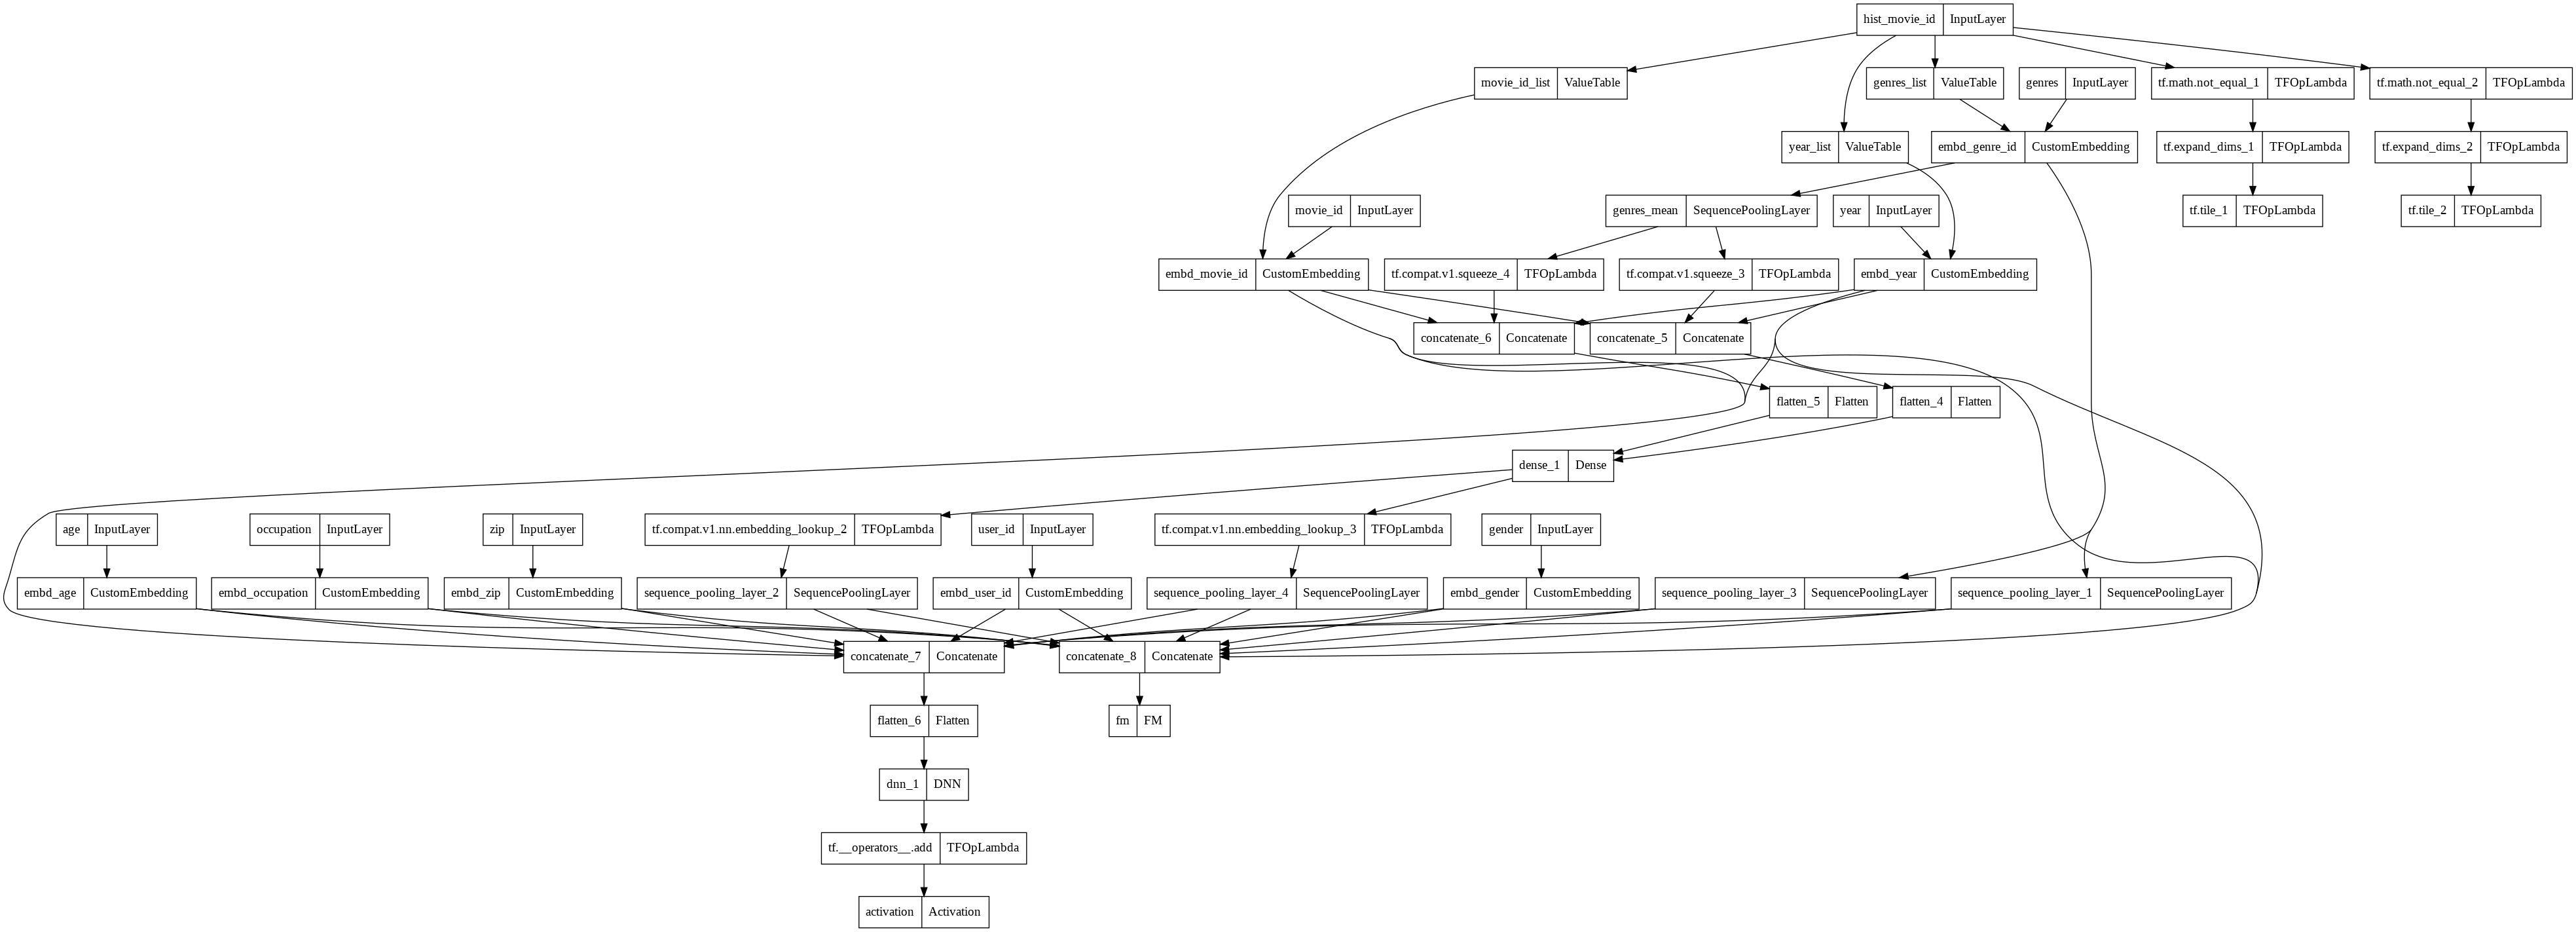

In [37]:
plot_model(rank_model)

In [38]:
rank_model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4), loss=binary_crossentropy)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)
history = rank_model.fit(rank_train, rank_train_label,
                    batch_size=BATCH_SIZE*8, 
                    epochs=NEPOCH,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stop,checkpoint])

Epoch 1/50
284/284 [==============================] - 106s 360ms/step - loss: 103.8599 - val_loss: 2.5004
Epoch 2/50
284/284 [==============================] - 101s 357ms/step - loss: 0.7347 - val_loss: 0.2786
Epoch 3/50
284/284 [==============================] - 101s 357ms/step - loss: 0.2209 - val_loss: 0.2295
Epoch 4/50
284/284 [==============================] - 101s 357ms/step - loss: 0.2032 - val_loss: 0.2180
Epoch 5/50
284/284 [==============================] - 101s 357ms/step - loss: 0.1939 - val_loss: 0.1941
Epoch 6/50
284/284 [==============================] - 101s 357ms/step - loss: 0.1869 - val_loss: 0.1856
Epoch 7/50
284/284 [==============================] - 101s 357ms/step - loss: 0.1813 - val_loss: 0.1796
Epoch 8/50
284/284 [==============================] - 101s 357ms/step - loss: 0.1765 - val_loss: 0.1776
Epoch 9/50
284/284 [==============================] - 102s 358ms/step - loss: 0.1720 - val_loss: 0.1714
Epoch 10/50
284/284 [==============================] - 102s 35

In [39]:
rank_model.load_weights('./rank_checkpoint/')

In [40]:
del rank_train
gc.collect()

17972

In [41]:
pred = rank_model.predict(rank_test, batch_size=BATCH_SIZE*8)

In [42]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = rank_test['user_id']
pred_df['movie_id'] = rank_test['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

In [43]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = match_test['user_id']
test_label_df['label'] = match_test_label.tolist()

In [44]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [45]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.02101049879112793

In [46]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.061804635761589406

In [47]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.4269370860927152